In [1]:
import arviz as az
import networkx as nx
import numpy as np
import pandas as pd
from pywhy_graphs.viz import draw
import pymc as pm
from statsmodels.genmod.families.links import Logit
import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
warnings.filterwarnings('ignore')

1\. Revisit the marriage, age,and happiness collider bias example from Chapter 6. Run models m6.9 and m6.10 again (pages 178–179). Compare these two models using both PSIS and WAIC. Which model is expected to make better predictions, according to these criteria, and which model yields the correct causal inference?

In [3]:
def sim_happiness(N_years=100, seed=1234):
    logit = Logit()
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, logit.inverse(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [4]:
d = sim_happiness(N_years=1000, seed=1977)
d.dtypes

age            int64
happiness    float64
married         bool
dtype: object

In [5]:
d.married = d.married.astype(int)
d.dtypes

age            int64
happiness    float64
married        int64
dtype: object

In [6]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
age,32.000,18.769,0.0,57.000
happiness,-0.000,1.214,-2.0,1.579
married,0.276,0.447,0.0,1.000


In [7]:
d2 = d[d.age > 17]
d2.age = (d.age - 18) / (65 - 18)

In [8]:
d2

,age,happiness,married
360,0.000000,0.526316,0
361,0.000000,0.736842,0
362,0.000000,0.947368,0
363,0.000000,1.789474,0
364,0.000000,1.368421,0
...,...,...,...
1295,0.978723,-1.578947,0
1296,0.978723,-1.789474,1
1297,0.978723,-2.000000,0
1298,0.978723,-0.105263,1


In [9]:
A = d2.age
H = d2.happiness
M = d2.married

with pm.Model() as m6_9:
    bA = pm.Normal("bA", 0., 2.)
    a = pm.Normal("a", mu=0., sigma=1., shape=2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a[M] + bA*A
    H = pm.Normal("A", mu=mu, sigma=sigma, observed=H)

In [10]:
with m6_9:
    t6_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bA, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [12]:
az.plot_trace(t6_9)

array([[<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

In [13]:
az.summary(t6_9, round_to=2, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
bA,-0.71,0.12,-0.88,-0.50
a[0],-0.22,0.06,-0.33,-0.12
a[1],1.27,0.09,1.14,1.41
sigma,0.99,0.02,0.96,1.03


In [14]:
A = d2.age
H = d2.happiness

with pm.Model() as m6_10:
    bA = pm.Normal("bA", 0., 2.)
    a = pm.Normal("a", mu=0., sigma=1.)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + bA*A
    H = pm.Normal("A", mu=mu, sigma=sigma, observed=H)

In [15]:
with m6_10:
    t6_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bA, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

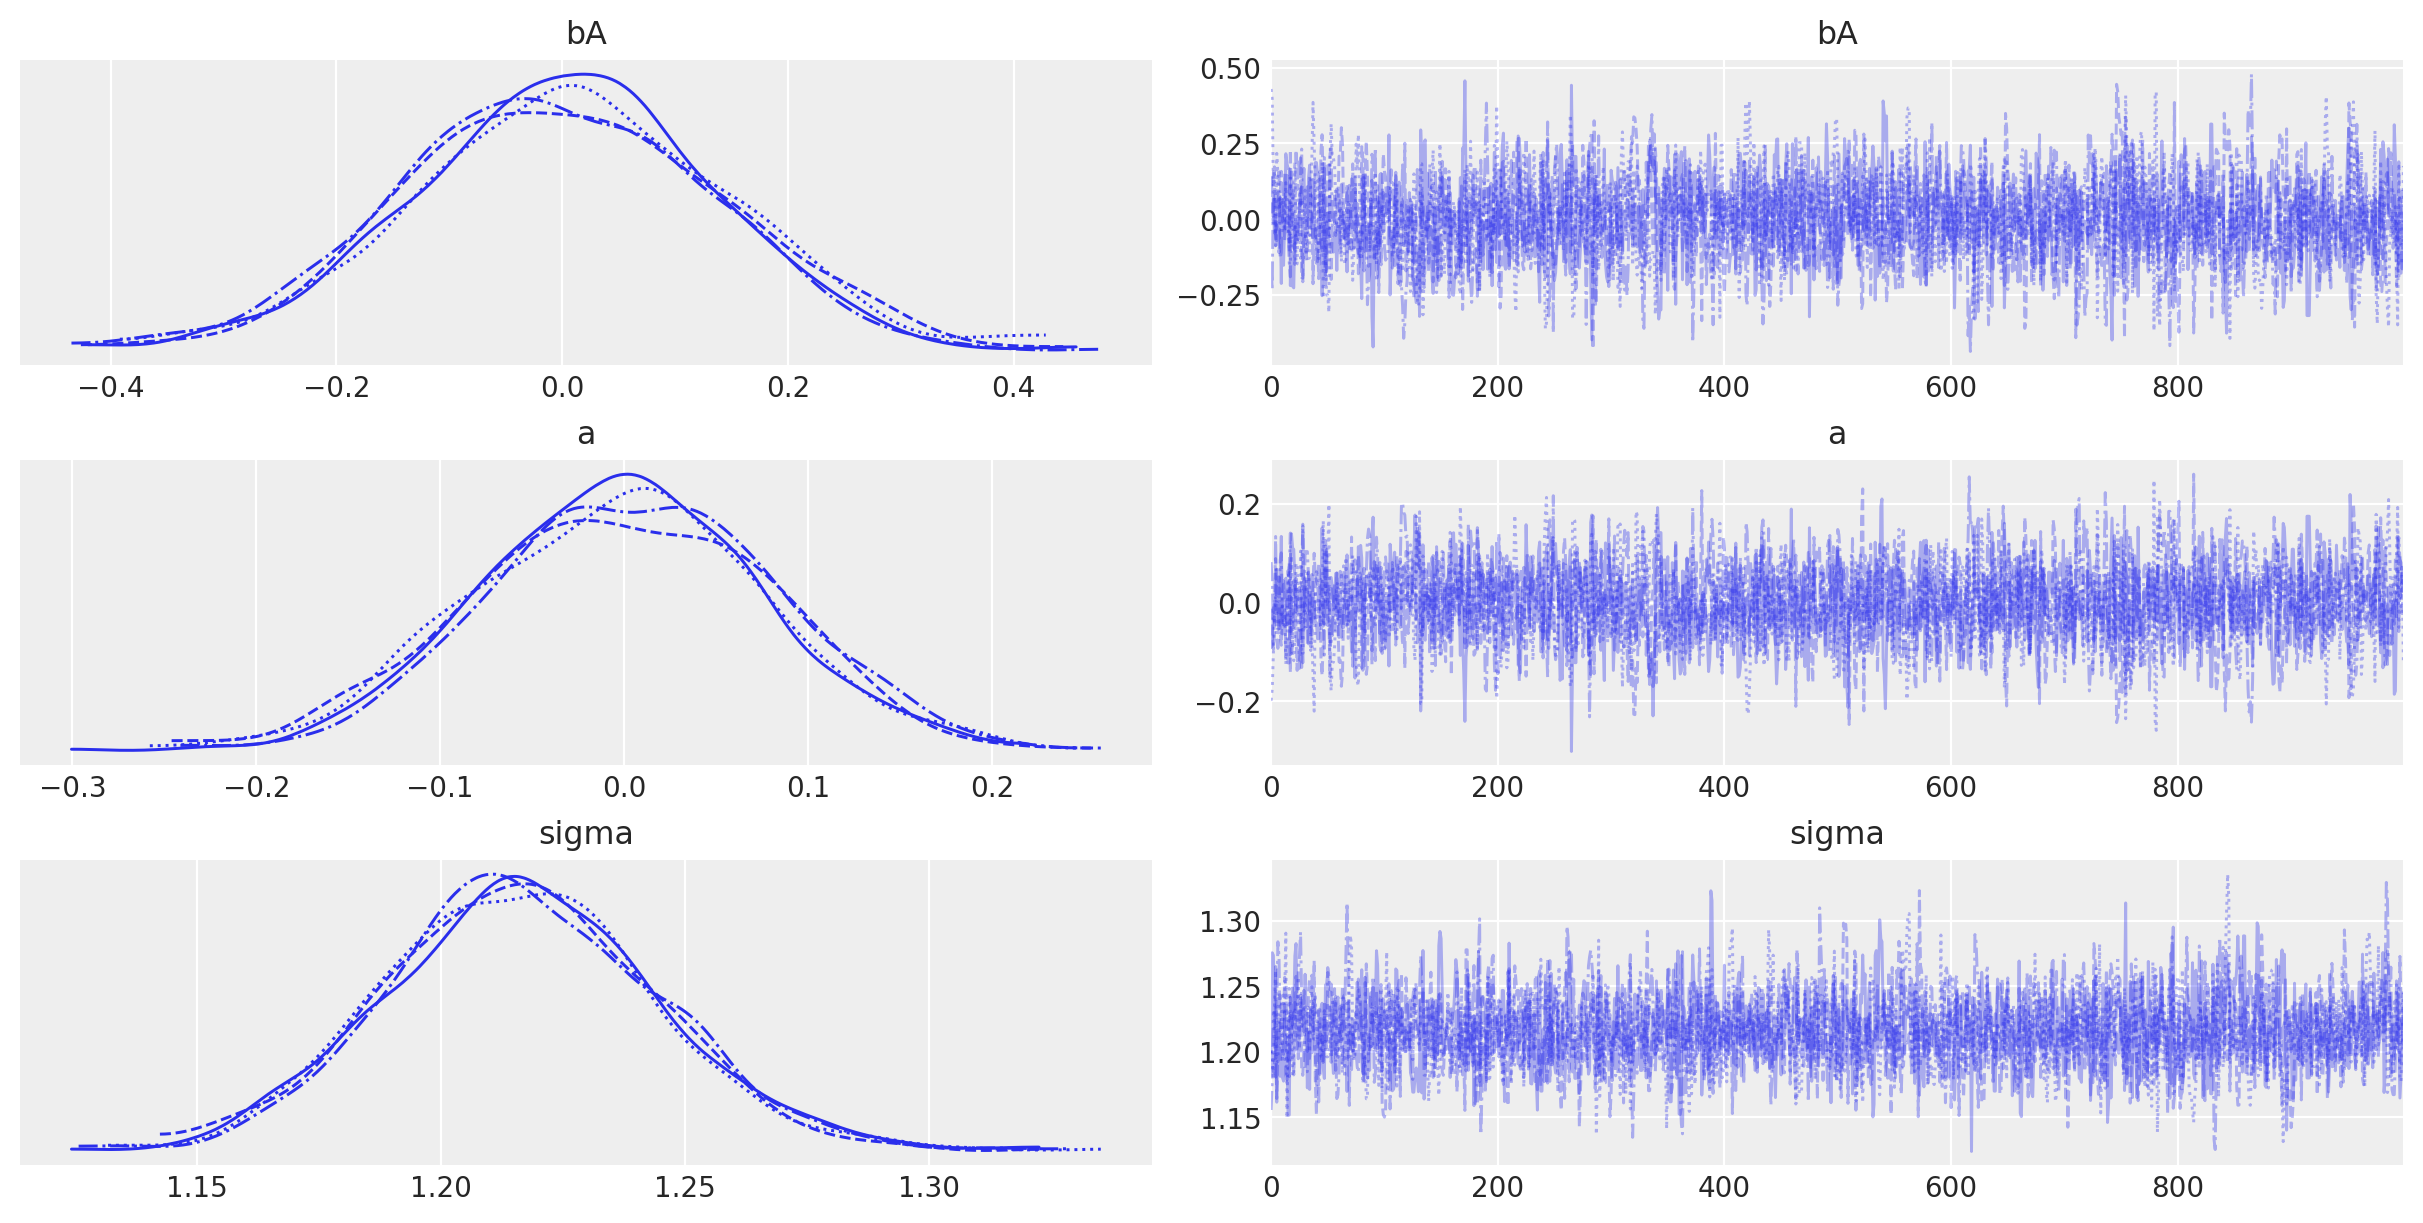

In [16]:
az.plot_trace(t6_10)

In [17]:
az.summary(t6_10, round_to=2, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
bA,0.00,0.14,-0.22,0.22
a,-0.00,0.08,-0.13,0.12
sigma,1.22,0.03,1.18,1.26


In [18]:
with m6_9:
    pm.compute_log_likelihood(t6_9)

In [19]:
with m6_10:
    pm.compute_log_likelihood(t6_10)

In [20]:
loo_t6_9 = az.loo(t6_9)
waic_t6_9 = az.waic(t6_9)
loo_t6_10 = az.loo(t6_10)
waic_t6_10 = az.waic(t6_10)

In [21]:
compare_loo = az.compare({"m6_9": loo_t6_9, "m6_10": loo_t6_10}, ic="loo")
compare_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m6_9,0,-1330.694804,3.569958,0.000000,0.986548,18.719080,0.000000,False,log
m6_10,1,-1518.757879,2.402139,188.063076,0.013452,13.656164,17.400255,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

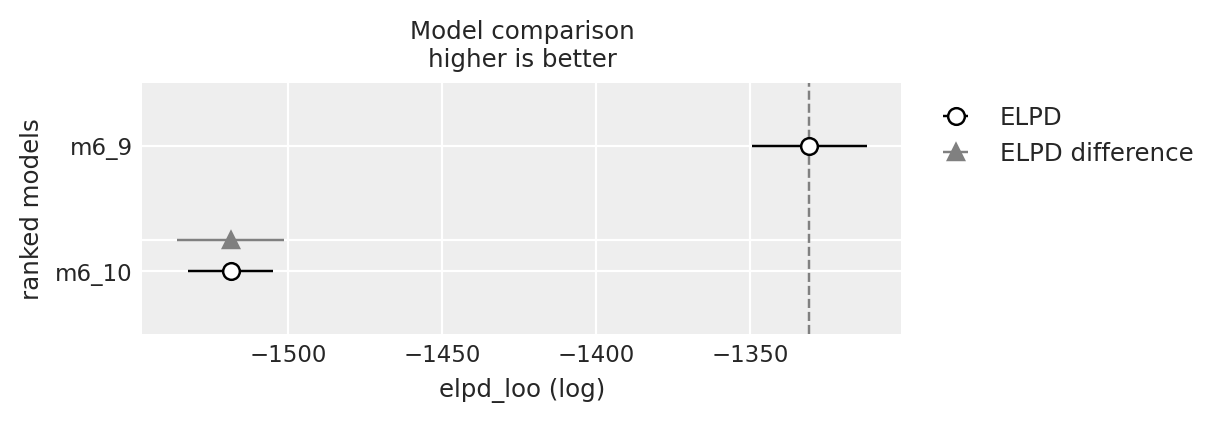

In [22]:
az.plot_compare(compare_loo)

In [23]:
compare_waic = az.compare({"m6_9": waic_t6_9, "m6_10": waic_t6_10}, ic="waic")
compare_waic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m6_9,0,-1330.689158,3.564313,0.000000,0.986557,18.718831,0.000000,False,log
m6_10,1,-1518.754444,2.398704,188.065286,0.013443,13.656068,17.400053,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

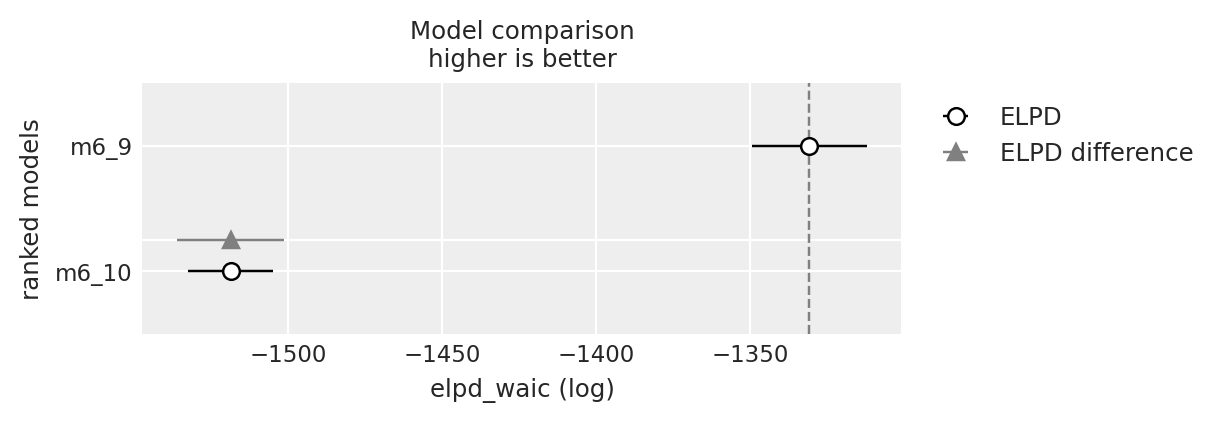

In [24]:
az.plot_compare(compare_waic)

2\. Reconsider the urban fox analysis from last week’s homework. On the basis of PSIS and WAIC scores, which combination of variables best predicts body weight (W, weight)? What causal interpretation can you assign each coefficient (parameter) from the best scoring model?

In [25]:
d = pd.read_csv("../../Data/foxes.csv", sep=",", header=0)
d.head(10)

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85
5,3,0.49,2,2.12,3.25
6,4,0.45,2,1.29,4.53
7,4,0.45,2,1.29,4.09
8,5,0.74,3,3.78,6.13
9,5,0.74,3,3.78,5.59


In [26]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
group,17.207,8.003,5.00,29.00
avgfood,0.752,0.198,0.41,1.03
groupsize,4.345,1.539,2.00,7.00
area,3.169,0.928,1.73,4.54
weight,4.530,1.184,2.78,6.31


In [27]:
d_standardized = d.copy()
d_standardized.avgfood = stats.zscore(d_standardized.avgfood)
d_standardized.groupsize = stats.zscore(d_standardized.groupsize)
d_standardized.area = stats.zscore(d_standardized.area)
d_standardized.weight = stats.zscore(d_standardized.weight)
d_standardized.head(10)

NameError: name 'stats' is not defined

In [28]:
az.summary(d_standardized.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
group,17.207,8.003,5.00,29.00
avgfood,0.752,0.198,0.41,1.03
groupsize,4.345,1.539,2.00,7.00
area,3.169,0.928,1.73,4.54
weight,4.530,1.184,2.78,6.31


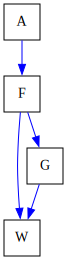

In [29]:
G = nx.DiGraph([("A", "F"), ("F", "W"), ("F", "G"), ("G", "W")])
draw(G, node_shapes="o")

In [30]:
W = d_standardized.weight.values
A = d_standardized.area.values
F = d_standardized.avgfood
G = d_standardized.groupsize

with pm.Model() as m1:
    bF = pm.Normal("bF", 0., 0.5)
    bG = pm.Normal("bG", 0., 0.5)
    bA = pm.Normal("bA", 0., 0.5)
    a = pm.Normal("a", mu=0., sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + bF*F + bG*G + bA*A
    W = pm.Normal("W", mu=mu, sigma=sigma, observed=W)
    t1 = pm.sample(1000, tune=1000)
    pm.compute_log_likelihood(t1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bF, bG, bA, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [31]:
W = d_standardized.weight.values
F = d_standardized.avgfood
G = d_standardized.groupsize

with pm.Model() as m2:
    bF = pm.Normal("bF", 0., 0.5)
    bG = pm.Normal("bG", 0., 0.5)
    a = pm.Normal("a", mu=0., sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + bF*F + bG*G
    W = pm.Normal("W", mu=mu, sigma=sigma, observed=W)
    t2 = pm.sample(1000, tune=1000)
    pm.compute_log_likelihood(t2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bF, bG, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [32]:
W = d_standardized.weight.values
A = d_standardized.area.values
G = d_standardized.groupsize

with pm.Model() as m3:
    bA = pm.Normal("bA", 0., 0.5)
    bG = pm.Normal("bG", 0., 0.5)
    a = pm.Normal("a", mu=0., sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + bG*G + bA*A
    W = pm.Normal("W", mu=mu, sigma=sigma, observed=W)
    t3 = pm.sample(1000, tune=1000)
    pm.compute_log_likelihood(t3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bA, bG, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [33]:
W = d_standardized.weight.values
F = d_standardized.avgfood

with pm.Model() as m4:
    bF = pm.Normal("bF", 0., 0.5)
    a = pm.Normal("a", mu=0., sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + bF*F
    W = pm.Normal("W", mu=mu, sigma=sigma, observed=W)
    t4 = pm.sample(1000, tune=1000)
    pm.compute_log_likelihood(t4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bF, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [34]:
W = d_standardized.weight.values
A = d_standardized.area.values

with pm.Model() as m5:
    bA = pm.Normal("bA", 0., 0.5)
    a = pm.Normal("a", mu=0., sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + bA*A
    W = pm.Normal("W", mu=mu, sigma=sigma, observed=W)
    t5 = pm.sample(1000, tune=1000)
    pm.compute_log_likelihood(t5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bA, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [35]:
loo_t1 = az.loo(t1)
loo_t2 = az.loo(t2)
loo_t3 = az.loo(t3)
loo_t4 = az.loo(t4)
loo_t5 = az.loo(t5)

In [36]:
compare_loo = az.compare({"m1": loo_t1, "m2": loo_t2, "m3": loo_t3, "m4": loo_t4, "m5": loo_t5}, ic="loo")
compare_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m4,0,-215.075079,1.590402,0.000000,6.022031e-01,6.166189,0.000000,False,log
m1,1,-216.930072,2.731926,1.854994,3.977969e-01,7.331991,4.222629,False,log
m3,2,-219.021797,2.564502,3.946718,0.000000e+00,7.424934,4.360963,False,log
m5,3,-220.942720,1.865836,5.867642,0.000000e+00,7.111211,3.919810,False,log
m2,4,-232.834282,2.041690,17.759203,1.474953e-11,6.252030,2.971498,False,log


In [37]:
az.summary(t1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bF,0.797,0.490,-0.009,1.547,0.010,0.007,2642.0,2432.0,1.0
bG,-0.259,0.156,-0.508,-0.018,0.003,0.002,2037.0,2005.0,1.0
bA,1.297,0.217,0.955,1.645,0.005,0.003,2183.0,2221.0,1.0
a,0.626,0.207,0.284,0.944,0.004,0.003,2695.0,2599.0,1.0
sigma,1.552,0.114,1.364,1.725,0.002,0.002,2411.0,2400.0,1.0


3\. Build a predictive model of the relationship shown on the cover of the book, the relationship between the timing of cherry blossoms and March temper- ature in the same year. The data are found in data(cherry_blossoms). Consider at least two different models (functional relationships) to predict doy with temp. You could for example compare a linear model with a qua- dratic model. Compare them with PSIS or WAIC.
Suppose March temperatures reach 9 degrees by the year 2050. What does your best model predict for the predictive distribution of the day-in-year that the cherry trees will blossom?

In [38]:
d = pd.read_csv("../../Data/cherry_blossoms.csv", sep=",", header=0)
d.head(10)

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN
5,806,NaN,NaN,NaN,NaN
6,807,NaN,NaN,NaN,NaN
7,808,NaN,NaN,NaN,NaN
8,809,NaN,NaN,NaN,NaN
9,810,NaN,NaN,NaN,NaN


In [39]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
year,1408.0,350.885,801.00,1882.0
doy,NaN,NaN,86.00,NaN
temp,NaN,NaN,5.06,NaN
temp_upper,NaN,NaN,5.78,NaN
temp_lower,NaN,NaN,3.60,NaN


In [40]:
d.dropna(subset=["temp", "doy"], inplace=True)

In [41]:
d.head(10)

,year,doy,temp,temp_upper,temp_lower
50,851,108.0,7.38,12.10,2.66
63,864,100.0,6.42,8.69,4.14
65,866,106.0,6.44,8.11,4.77
88,889,104.0,6.83,8.48,5.19
90,891,109.0,6.98,8.96,5.00
91,892,108.0,7.11,9.11,5.11
93,894,106.0,6.98,8.40,5.55
94,895,104.0,7.08,8.57,5.58
95,896,104.0,7.20,8.69,5.72
101,902,102.0,7.50,8.95,6.06


In [42]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
year,1533.395,291.123,1123.00,1978.00
doy,104.921,6.258,95.00,114.00
temp,6.100,0.683,5.00,7.13
temp_upper,6.938,0.812,5.57,7.98
temp_lower,5.264,0.762,4.12,6.40


In [43]:
d_standardized = d.copy()
d_standardized.doy = stats.zscore(d_standardized.doy)
d_standardized.temp = stats.zscore(d_standardized.temp)
d_standardized.head(100)

NameError: name 'stats' is not defined

In [44]:
D = d_standardized.doy.values
T = d_standardized.temp.values

with pm.Model() as m3a:
    a = pm.Normal("a", mu=0., sigma=10.)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=D)
    t3a = pm.sample(1000, tune=1000)
    pm.compute_log_likelihood(t3a)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [45]:
D = d_standardized.doy.values
T = d_standardized.temp.values

with pm.Model() as m3b:
    a = pm.Normal("a", mu=0., sigma=10.)
    b = pm.Normal("b", mu=0., sigma=10.)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + b*T
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=D)
    t3b = pm.sample(1000, tune=1000)
    pm.compute_log_likelihood(t3b)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [46]:
D = d_standardized.doy.values
T = d_standardized.temp.values

with pm.Model() as m3c:
    a = pm.Normal("a", mu=0., sigma=10.)
    b = pm.Normal("b", mu=0., sigma=10.)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + b*T + b*T*T
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=D)
    t3c = pm.sample(1000, tune=1000)
    pm.compute_log_likelihood(t3c)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [47]:
az.compare({"t3a": t3a, "t3b": t3b, "t3c": t3c})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
t3c,0,-2518.763266,2.813335,0.000000,1.000000e+00,20.451470,0.000000,False,log
t3b,1,-2520.538535,2.863664,1.775269,2.505829e-12,20.414381,1.018582,False,log
t3a,2,-2561.415436,1.961021,42.652171,0.000000e+00,19.839686,7.311704,False,log


In [48]:
az.summary(t3b)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,118.788,1.846,115.906,121.683,0.050,0.036,1352.0,1476.0,1.0
b,-2.282,0.300,-2.736,-1.796,0.008,0.006,1347.0,1455.0,1.0
sigma,5.925,0.154,5.695,6.175,0.004,0.003,1610.0,1568.0,1.0


In [49]:
t = (9. - d.temp.mean()) / d.temp.std()

In [50]:
values = np.random.normal(.001 -.327*t, .947, 1000)

In [51]:
values = values*d.doy.std() + d.doy.mean()

array([[<Axes: title={'center': 'x'}>]], dtype=object)

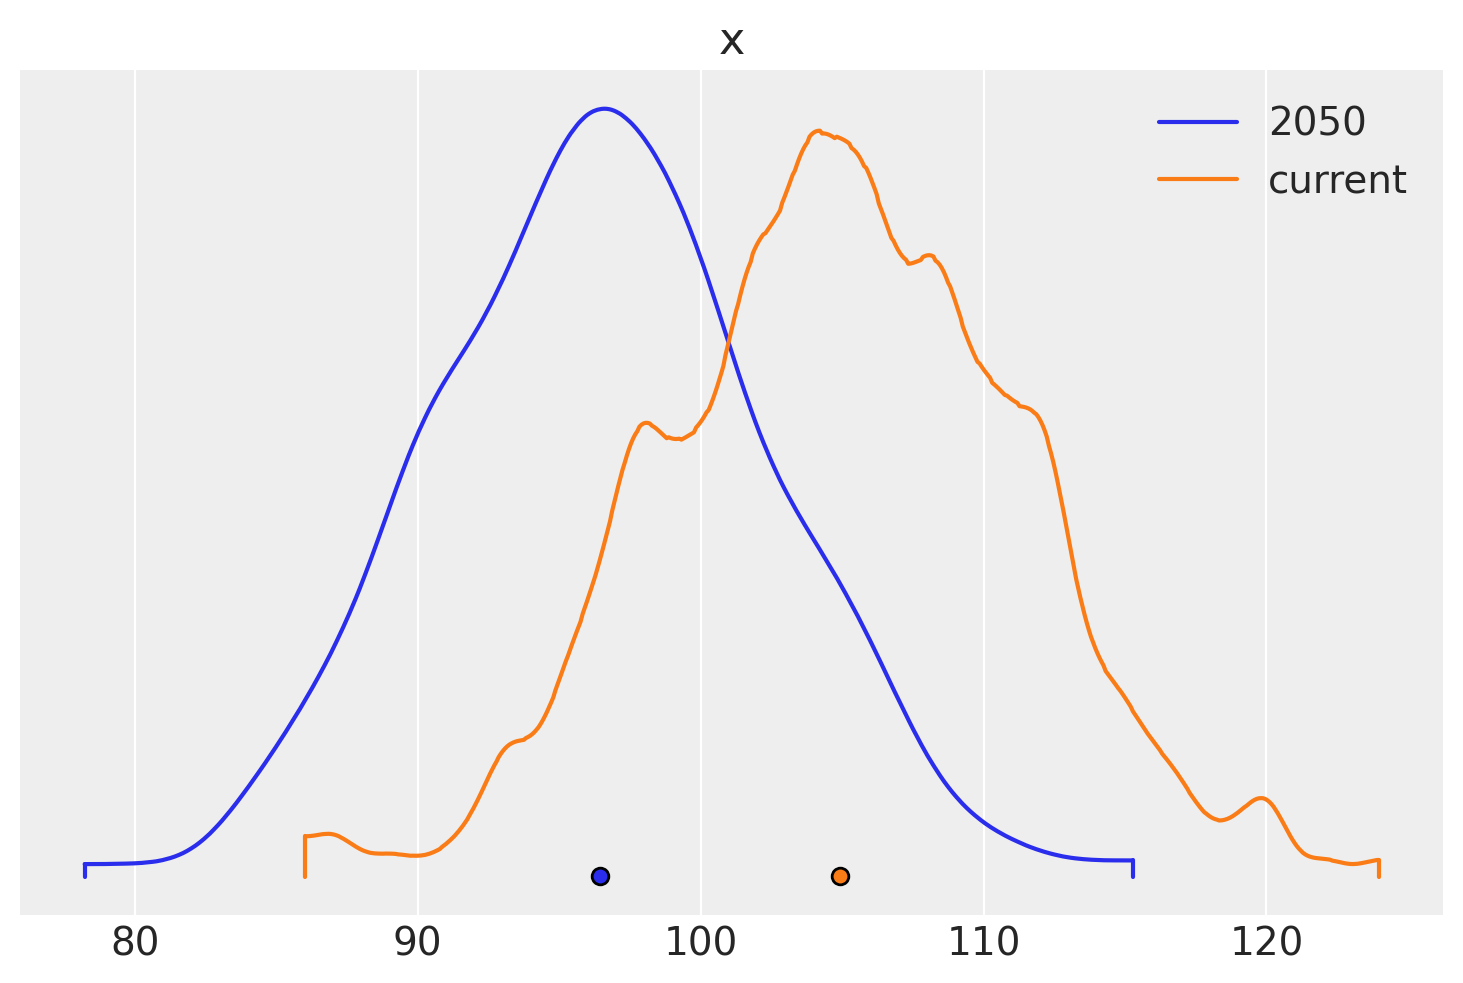

In [52]:
az.plot_density([values, d.doy.values], data_labels=["2050", "current"], hdi_prob=1.)